# Get Nightlight Data from Google Earth Engine using GEEMap

In [2]:
import ee
import geemap

## Authenticate & Initialize GEE

Requires a [Google Cloud Project](https://console.cloud.google.com/projectcreate) and to enable the [Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com) for the project. Find detailed instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication).

In [2]:
# ee.Authenticate()
# errors if I run with gee environment
# https://stackoverflow.com/questions/75666380/attributeerror-module-ipython-utils-traitlets-has-no-attribute-unicode
# run with anaconda base environment

In [3]:
ee.Initialize()

## Create a GEEMap Object

In [4]:
m = geemap.Map(
    center=[-5, 15], 
    zoom=3, 
    basemap = 'Esri.WorldImagery'
)

## Add Layers to the Map

In [5]:
# add nightlights median
# https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG
dataset_night = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG') \
                  .filter(ee.Filter.date('2022-01-01', '2023-11-01'))
nighttime = dataset_night.select('avg_rad')
image_night = nighttime.median()
nighttimeVis = {'min': 0.0, 'max': 2.0}
m.addLayer(image_night, nighttimeVis, 'Nighttime')


In [6]:
# add WorldPop population density layer
# https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#description
dataset_pop = ee.ImageCollection('WorldPop/GP/100m/pop') \
                  .filter(ee.Filter.date('2020-01-01', '2020-12-31'))
pop = dataset_pop.select('population')
image_pop = pop.median()
popVis = {
    'min': 0.0, 
    'max': 20.0,
    'palette': ['24126c', '1fff4f', 'd4ff50'],
    'opacity': 0.5
}
m.addLayer(image_pop, popVis, 'Population')


In [7]:
# overlay country boundaries with white borders
countries = ee.FeatureCollection('FAO/GAUL/2015/level0')
# styleParams = {
#   'fillColor': '00000000',
#   'color': 'ffffff',
#   'width': 1.0,
#   'lineType': 'solid'
# }
# style = {'color': 'ffffff82', 'width': 1, 'lineType': 'solid', 'fillColor': 'ffffff00'}
m.addLayer(countries, {}, 'Countries')

# note: this isn't styling the countries correctly
# manually change the country layer to have a transparent fill on the interactive map
# note do not rerun these cells multiple times, seems to freeze the map

In [8]:
# add place names
# https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0
m.add_basemap('CartoDB.DarkMatterOnlyLabels')
# m.remove_layer('CartoDB.VoyagerOnlyLabels') # doesn't work

## Import Control Sites

Get the control sites for Nigeria and Sierra Leone respectively. 

In [9]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [10]:
# read in excel file
sl_ctrl_df = pd.read_excel(
    'data/pg/SLBU USTDA Site Survey Summary Data.xlsx', 
    sheet_name='Summary Info',
    header=1    
)
# keep certain columns and rows
sl_ctrl_df = sl_ctrl_df.iloc[0:40, 1:10]
# turn this into a geodataframe

# create a geometry column
geometry = [Point(xy) for xy in zip(sl_ctrl_df['Longitude'], sl_ctrl_df['Latitude'])]
# create a geodataframe
sl_ctrl_gdf = gpd.GeoDataFrame(sl_ctrl_df, crs='EPSG:4326', geometry=geometry)
# gdf.head(10)
# remove periods from column names
sl_ctrl_gdf.columns = sl_ctrl_gdf.columns.str.replace('.', '')

# convert the geodataframe to an ee feature collection
sl_ctl_fc = geemap.geopandas_to_ee(sl_ctrl_gdf)

# add the geodataframe to the map in yellow
m.addLayer(sl_ctl_fc, {'color': 'ffff00'}, 'SL Control Sites')

In [12]:
# read in nigeria control sites
ng_ctrl_df = pd.read_excel(
    'data/pg/NGBU Site Survey Data.xlsx', 
    sheet_name='Sheet1',
    header=1    
)
# keep certain columns and rows
ng_ctrl_df = ng_ctrl_df.iloc[0:11, 1:9]
ng_ctrl_df
# create a geometry column
geometry = [Point(xy) for xy in zip(ng_ctrl_df['Longitude'], ng_ctrl_df['Latitude'])]
# create a geodataframe
ng_ctrl_gdf = gpd.GeoDataFrame(ng_ctrl_df, crs='EPSG:4326', geometry=geometry)
# remove periods from column names
ng_ctrl_gdf.columns = ng_ctrl_gdf.columns.str.replace('.', '')
# convert the geodataframe to an ee feature collection
ng_ctl_fc = geemap.geopandas_to_ee(ng_ctrl_gdf)
# add the geodataframe to the map in yellow
m.addLayer(ng_ctl_fc, {'color': 'ffff00'}, 'NG Control Sites')

In [13]:
# read in site_data.csv for CBIL
cbil_df = pd.read_csv('data/cbil/site_data.csv')

# create a geometry column
geometry = [Point(xy) for xy in zip(cbil_df['metadata.project.longitude'], cbil_df['metadata.project.latitude'])]
# replace periods in column names
cbil_df.columns = cbil_df.columns.str.replace('.', '')
# create a geodataframe
cbil_gdf = gpd.GeoDataFrame(cbil_df, crs='EPSG:4326', geometry=geometry)
# convert the geodataframe to an ee feature collection
cbil_fc = geemap.geopandas_to_ee(cbil_gdf)
# add the geodataframe to the map in purple
m.addLayer(cbil_fc, {'color': 'ff00ff'}, 'CBIL Sites')


In [14]:
# read in site_data.csv for PowerGen
pg_df = pd.read_csv('data/pg/site_data.csv')

# create a geometry column
geometry = [Point(xy) for xy in zip(pg_df['longitude'], pg_df['latitude'])]
# replace periods in column names
pg_df.columns = pg_df.columns.str.replace('.', '')
# create a geodataframe
pg_gdf = gpd.GeoDataFrame(pg_df, crs='EPSG:4326', geometry=geometry)
# convert the geodataframe to an ee feature collection
pg_fc = geemap.geopandas_to_ee(pg_gdf)
# add the geodataframe to the map in orange
m.addLayer(pg_fc, {'color': 'ff8000'}, 'PG Sites')


In [ ]:
# zoom into Siera Leone
m.centerObject(countries.filter(ee.Filter.eq('ADM0_NAME', 'Sierra Leone')))
m


## Get Nightlight Values for Sierra Leone Sites

In [ ]:
# pull out just Sierra Leone sites from geodataframes
sl_ctrl_gdf = sl_ctrl_gdf
sl_pg_gdf = pg_gdf[pg_gdf['country'] == 'Sierra Leone']
sl_cbil_gdf = cbil_gdf[cbil_gdf['country'] == 'Sierra Leone']

# add a column to tag where each site is from
sl_ctrl_gdf['site_type'] = 'Control'
sl_pg_gdf['site_type'] = 'PowerGen'
sl_cbil_gdf['site_type'] = 'CBIL'

# add a site name column
sl_ctrl_gdf['site_name'] = sl_ctrl_gdf['Community']
sl_pg_gdf['site_name'] = sl_pg_gdf['site_name']
sl_cbil_gdf['site_name'] = sl_cbil_gdf['site']


# add a date commissioned column
sl_ctrl_gdf['date_commissioned'] = '2030-01-01' # date way in the future
sl_pg_gdf['date_commissioned'] = sl_pg_gdf['date_commissioned']
sl_cbil_gdf['date_commissioned'] = sl_cbil_gdf['metadataprojectcod'].to_string()[7:17]

# check data types
sl_cbil_gdf


In [16]:

print("Shape of sl_ctrl_gdf is ", sl_ctrl_gdf.shape)
print("Shape of sl_pg_gdf is ", sl_pg_gdf.shape)
print("Shape of sl_cbil_gdf is ", sl_cbil_gdf.shape)

# filter out Manowa Junction because coordinates are in another country
sl_pg_gdf = sl_pg_gdf[sl_pg_gdf['site_name'] != 'Manowa Junction']
print("New shape of sl_pg_gdf is ", sl_pg_gdf.shape)

# recreate feature collections of each
sl_ctrl_fc = geemap.geopandas_to_ee(sl_ctrl_gdf)
sl_pg_fc = geemap.geopandas_to_ee(sl_pg_gdf)
sl_cbil_fc = geemap.geopandas_to_ee(sl_cbil_gdf)


Shape of sl_ctrl_gdf is  (40, 13)
Shape of sl_pg_gdf is  (38, 11)
Shape of sl_cbil_gdf is  (17, 13)
New shape of sl_pg_gdf is  (37, 11)


In [17]:
# create 1km buffer around each site
sl_ctrl_fc_buffer = sl_ctrl_fc.map(lambda f: f.buffer(1000))
sl_pg_fc_buffer = sl_pg_fc.map(lambda f: f.buffer(1000))
sl_cbil_fc_buffer = sl_cbil_fc.map(lambda f: f.buffer(1000))

# add the buffers to the map with 0.5 alpha
# m.addLayer(sl_ctrl_fc_buffer, {'color': 'ffff00', 'opacity': 0.5}, 'SL Control Sites Buffer')
# m.addLayer(sl_pg_fc_buffer, {'color': 'ff8000', 'opacity': 0.5}, 'SL PG Sites Buffer')
# m.addLayer(sl_cbil_fc_buffer, {'color': 'ff00ff', 'opacity': 0.5}, 'SL CBIL Sites Buffer')

# merge the buffers into 1 feature collection
sl_buffers = sl_ctrl_fc_buffer.merge(sl_pg_fc_buffer).merge(sl_cbil_fc_buffer)

In [ ]:
# get the nighttime values for each buffer
# https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG
dataset_night = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG') \
                  .filter(ee.Filter.date('2014-01-01', '2024-01-01'))
nighttime_ic = dataset_night.select('avg_rad')
nighttime_ic

# check CRS
# nighttime_ic.first().projection().getInfo()
# gives EPSG:4326
# 117 images in the collection

In [ ]:
# loop over image collection, create an python list of all images
nighttime_list = []
size = nighttime_ic.size().getInfo()
start_date = nighttime_ic.first().date()
current_date = start_date
next_date = current_date.advance(1, 'month')
for i in range(0, size):
    nighttime_image = nighttime_ic.filterDate(current_date, next_date).first()
    nighttime_list.append(nighttime_image)
    current_date = current_date.advance(1, 'month')
    next_date = current_date.advance(1, 'month')
# len(nighttime_list)
nighttime_list[-1]


In [ ]:
# loop over images in image collection to apply reduceRegions
nighttime_reduced = []

for i in range(0, size):
    nighttime_reduced.append(nighttime_list[i].reduceRegions(
        collection=sl_buffers, 
        reducer=ee.Reducer.mean(), 
        scale=150,
        crs='EPSG:4326'
))
# takes 35 seconds for scale of 30m for 10 year of data
# takes 10 seconds for scale of 150m for 10 year of data
# takes 6.1 seconds for scale of 450m for 10 year of data
# caches the results
nighttime_reduced[0]

In [ ]:
image1 = nighttime_reduced[0]
image1village1 = image1.getInfo()['features'][0]

mean = image1village1['properties']['mean']
type = image1village1['properties']['site_type']
date_commissioned = image1village1['properties']['date_commissioned']
site_name = image1village1['properties']['site_name']
# image_date = image1.getInfo()['properties']['system:index']

# date = '20140101'
# mean = 0.0081
# type = 'Control'
# date_commissioned = '2030-01-01'
# site_name = 'Nameofvillage'

In [ ]:
# format date
start_date = nighttime_ic.first().date()
start_date.format('YYYY-MM-dd').getInfo()

In [ ]:
# create a dataframe to store the results
df = pd.DataFrame(columns=[
    'site_name',
    'site_type', 
    'date_commissioned', 
    'image_date', 
    'image_value'
])
start_date = nighttime_ic.first().date()
ic_size = nighttime_ic.size().getInfo()
villages_size = sl_buffers.size().getInfo()

# loop over the list of reduced images to populate the dataframe
for i in range(0, ic_size):
    print("Processing image ", i+1, " of ", ic_size)
    images = nighttime_reduced[i]
    for j in range(0, villages_size):
        print(i+1, ": Processing village ", j+1, " of ", villages_size)
        village_image = images.getInfo()['features'][j]
        image_date = start_date.advance(i, 'month').format('YYYY-MM-dd').getInfo()
        image_value = village_image['properties']['mean']
        type = village_image['properties']['site_type']
        date_commissioned = village_image['properties']['date_commissioned']
        site_name = village_image['properties']['site_name']
        new_row = {
            'site_name': site_name,
            'site_type': type,
            'date_commissioned': date_commissioned,
            'image_date': image_date,
            'image_value': image_value
        }
        df.loc[len(df)] = new_row

In [ ]:
df

In [25]:
# write df to csv
df.to_csv('data/nightlight_values.csv', index=False)

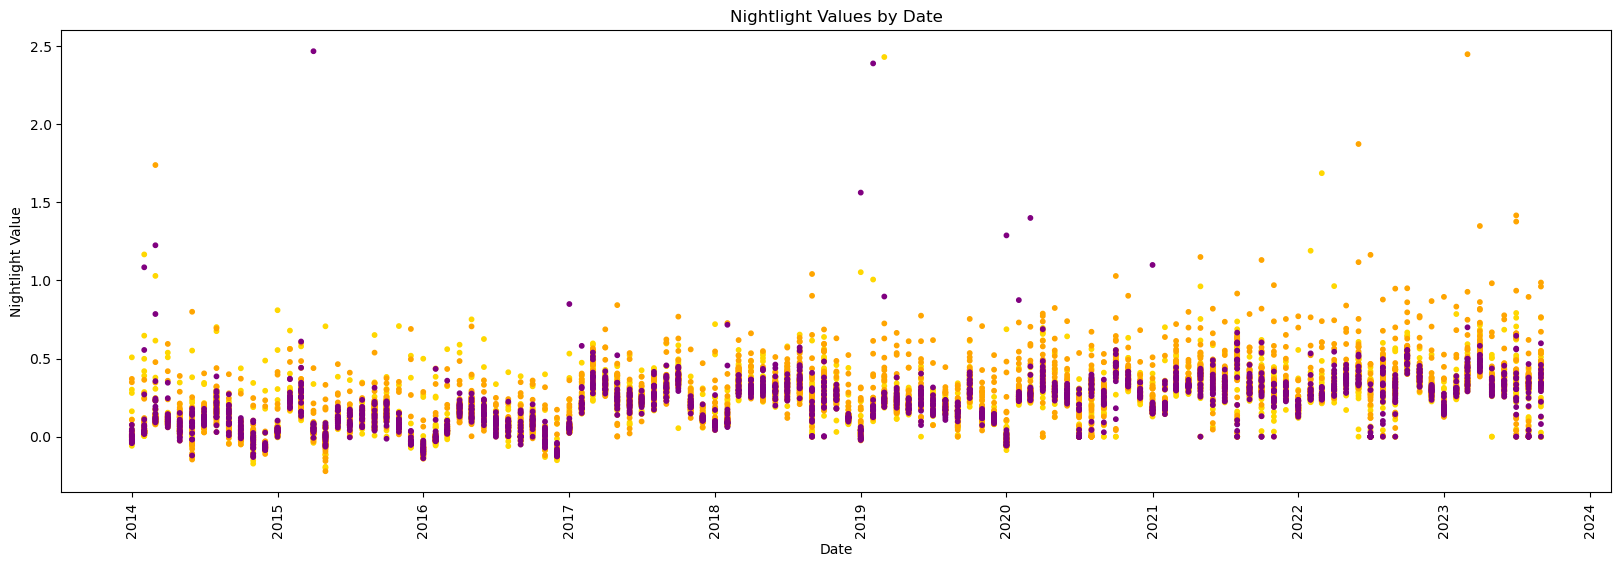

In [62]:
# plot the image values by date with a different color for each site_type
import matplotlib.pyplot as plt

df['image_datetime'] = pd.to_datetime(df['image_date'])

plt.figure(figsize=(20,6))
plt.title('Nightlight Values by Date')
plt.xlabel('Date')
plt.ylabel('Nightlight Value')
# create a scatter plot with different colors for each site type
colors = {'Control': 'gold', 'PowerGen': 'orange', 'CBIL': 'purple'}
plt.scatter(df['image_datetime'], df['image_value'], s=10, c=df['site_type'].apply(lambda x: colors[x]))
# rotate the x axis labels
plt.xticks(rotation=90)
plt.show()


In [60]:
# figure out which sites have image_values of higher than 2
outliers = df[df['image_value'] > 3]

# show the site_names of the outliers
outliers['site_name'].unique()

# filter out these 3 outliers, all sites that are not in ['Pepel', 'Kainkordu', 'Roten']
df = df[~df['site_name'].isin(['Pepel', 'Kainkordu', 'Roten'])]
# TODO look into these outliners!!

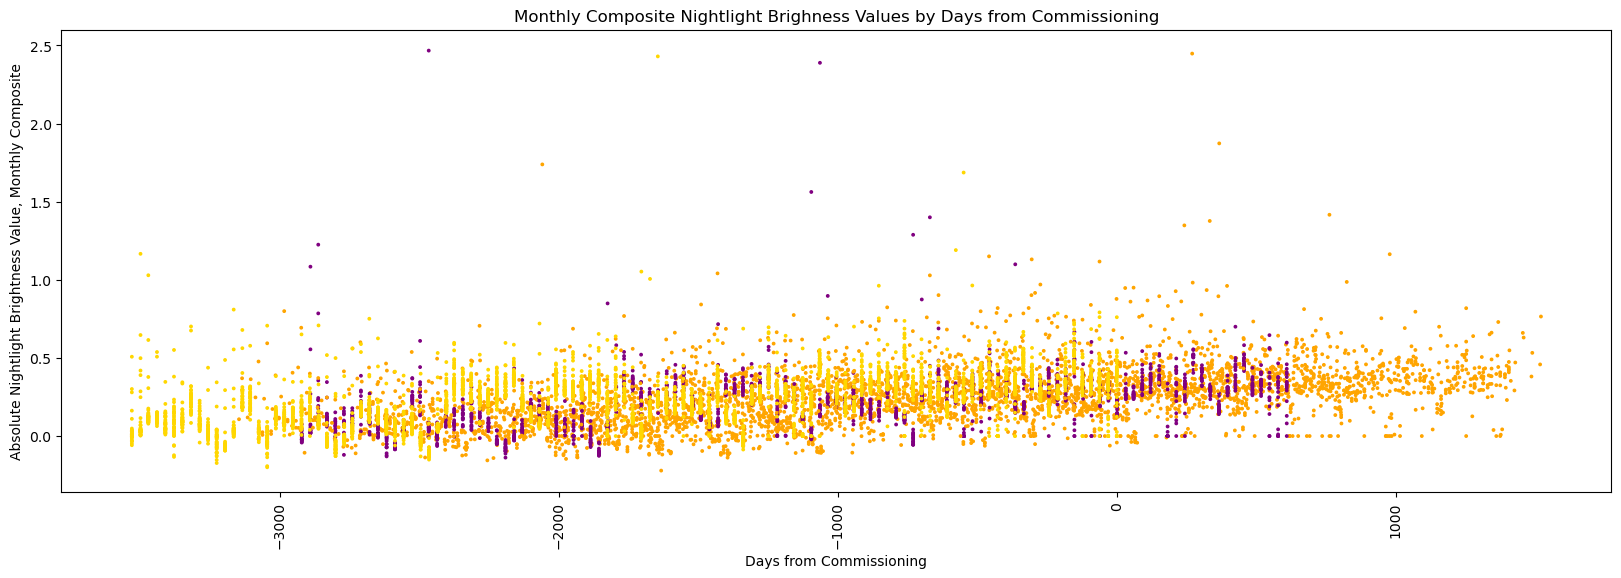

In [ ]:
# create column that takes the difference between image_datetime and datetime_commissioned
df.loc[df['site_type'] == 'Control', 'date_commissioned'] = '2023-09-01'
df['datetime_commissioned'] = pd.to_datetime(df['date_commissioned'])
df['time_diff'] = (df['image_datetime'] - df['datetime_commissioned']).dt.days

# plot the image_values by time_diff with a different color for each site_type
plt.figure(figsize=(20,6))
plt.title('Monthly Composite Nightlight Brighness Values by Days from Commissioning')
plt.xlabel('Days from Commissioning')
plt.ylabel('Absolute Nightlight Brightness Value, Monthly Composite')
# create a scatter plot with different colors for each site type
colors = {'Control': 'gold', 'PowerGen': 'orange', 'CBIL': 'purple'}
plt.scatter(df['time_diff'], df['image_value'], s=3, c=df['site_type'].apply(lambda x: colors[x]))
# rotate the x axis labels
plt.xticks(rotation=90)
plt.show()
# set y-axis limit to 1.5
plt.ylim(-0.5, 1.5)


In [1]:
m

NameError: name 'm' is not defined